In [47]:
import time
import random
import unidecode
import string
import re
import requests
import matplotlib.pyplot as plt
import torch

torch.backends.cudnn.deterministic = True

In [2]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device('cpu')

TEXT_PORTION_SIZE = 200

NUM_ITER = 5000
LEARNING_RATE = 0.005
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
NUM_HIDDEN_LAYERS = 1

print('Device:', DEVICE)

Device: cpu


In [50]:
url = "https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/17-Deep-Learning/17-RNN/test.txt"
response = requests.get(url)

# convert special characters
textfile = unidecode.unidecode(response.text)

# strip extra whitespaces
textfile = re.sub(' +',' ', textfile)

TEXT_LENGTH = len(textfile)

print(f'Number of characters in text: {TEXT_LENGTH}')

Number of characters in text: 84658


In [6]:
random.seed(RANDOM_SEED)

def random_portion(textfile):
    start_index = random.randint(0, TEXT_LENGTH - TEXT_PORTION_SIZE)
    end_index = start_index + TEXT_PORTION_SIZE + 1
    return textfile[start_index:end_index]

print(random_portion(textfile))

heck with the vaccine provider.

If you're traveling away from Madison before your second dose, we encourage you to get your first dose on campus now and obtain a second dose once you reach your new lo


In [7]:
def char_to_tensor(text):
    lst = [string.printable.index(c) for c in text]
    tensor = torch.tensor(lst).long()
    return tensor

print(char_to_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [8]:
def draw_random_sample(textfile):    
    text_long = char_to_tensor(random_portion(textfile))
    inputs = text_long[:-1]
    targets = text_long[1:]
    return inputs, targets

In [9]:
draw_random_sample(textfile)

(tensor([ 0, 94, 24, 27, 94, 21, 10, 29, 14, 27, 94, 24, 15, 94, 26, 30, 10, 27,
         10, 23, 29, 18, 23, 14, 94, 10, 23, 13, 94, 34, 24, 30, 27, 94, 37, 10,
         13, 16, 14, 27, 94, 37, 10, 13, 16, 14, 94, 18, 23, 13, 18, 12, 10, 29,
         14, 28, 94, 63, 11, 30, 18, 21, 13, 18, 23, 16, 94, 10, 12, 12, 14, 28,
         28, 94, 16, 27, 10, 23, 29, 14, 13, 75, 63, 96, 54, 14, 14, 94, 29, 17,
         14, 94, 56, 23, 18, 31, 14, 27, 28, 18, 29, 34, 94, 43, 14, 10, 21, 29,
         17, 94, 54, 14, 27, 31, 18, 12, 14, 28, 94, 32, 14, 11, 28, 18, 29, 14,
         94, 15, 24, 27, 94, 22, 24, 27, 14, 94, 18, 23, 15, 24, 27, 22, 10, 29,
         18, 24, 23, 94, 10, 11, 24, 30, 29, 94, 26, 30, 10, 27, 10, 23, 29, 18,
         23, 14, 94, 10, 23, 13, 94, 18, 28, 24, 21, 10, 29, 18, 24, 23, 75, 96,
         96, 58, 17, 18, 21, 14, 94,  1,  4, 94, 13, 10, 34, 28, 94, 18, 28, 94,
         29, 17]),
 tensor([94, 24, 27, 94, 21, 10, 29, 14, 27, 94, 24, 15, 94, 26, 30, 10, 27, 10,
         

In [10]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, embed_size,
                 hidden_size, output_size, num_layers):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embed = torch.nn.Embedding(num_embeddings=input_size,
                                        embedding_dim=embed_size)
        self.rnn = torch.nn.LSTM(input_size=embed_size,
                                 hidden_size=hidden_size,
                                 num_layers=num_layers)
        self.fc = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, features, hidden_and_cell_state):
        # text dim: [1] -> [[1]] (features = 1 character)
        features = features.view(1, -1)
        
        # embedded dim = [text length, batch size, embedding dim] = [1, 1, embedding dim]
        embedded = self.embed(features)
        
        output, hidden_and_cell_state = self.rnn(embedded, hidden_and_cell_state)
        # 1. output dim: [sentence length, batch size, hidden dim] = [1, 1, hidden dim]
        # 2. (last) hidden dim: [num layers, batch size, hidden dim] = [num layers, 1, hidden dim]
        # 3. cell dim: [num layers, batch size, hidden dim] = [num layers, 1, hidden dim]
        
        output.squeeze_(0)
        output = self.fc(output)
        return output, hidden_and_cell_state
      
    def init_zero_state(self):
        init_hidden = torch.zeros(self.num_layers, 1, self.hidden_size).to(DEVICE)
        init_cell = torch.zeros(self.num_layers, 1, self.hidden_size).to(DEVICE)
        return (init_hidden, init_cell)

In [11]:
torch.manual_seed(RANDOM_SEED)
model = RNN(len(string.printable), EMBEDDING_DIM, HIDDEN_DIM,
            len(string.printable), NUM_HIDDEN_LAYERS)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [12]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    ## based on https://github.com/spro/practical-pytorch/
    ## blob/master/char-rnn-generation/char-rnn-generation.ipynb

    hidden_and_cell_state = model.init_zero_state()
    prime_input = char_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden_and_cell_state = model(prime_input[p].to(DEVICE), hidden_and_cell_state)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden_and_cell_state = model(inp.to(DEVICE), hidden_and_cell_state)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = string.printable[top_i]
        predicted += predicted_char
        inp = char_to_tensor(predicted_char)

    return predicted

Time elapsed: 0.01 min
Iteration 0 | Loss 4.64


ThzgrY
$b$)"zIHHpx;1d0ZT)PgJwoeQxoZ<%hS=(]j%6#VEo,H5}PE=(uj'i6rs1B2:.a$>ZMeQ]iTC/>Ye0)N<92yyW5&Db[m*+09 )DHG};x1"k.0auIT:6bWkWP[HSWlNf`Dag
 <|Y%ID73v"_U	0]czB=
w?Uo72@C#/VjHB	7#nllLE w?y&_# dNz9g 

Time elapsed: 0.80 min
Iteration 200 | Loss 2.16


Thappto COVID-19 ining bus a thay an can in an galding earctione campus ases..
Therume ratitior. Yunbe C2)(ailuss the ant and fots ane, to parching Vof stay of app cams bafible sot accing the.
In is and 

Time elapsed: 1.55 min
Iteration 400 | Loss 2.29


Th-als "immus from ans will pose arne thead to you app ento a natited for as or thin clmoutive test entin neing or and froblo or thoy the for they Sialt fquare not an your or wharding bivimison consin c 

Time elapsed: 2.29 min
Iteration 600 | Loss 1.84


Thist on you will the chant indito redice shouls as record to in a quirs a to and unding baily you chan at position, on to this be an excif thave not motuct the Wiscest resintir a sat

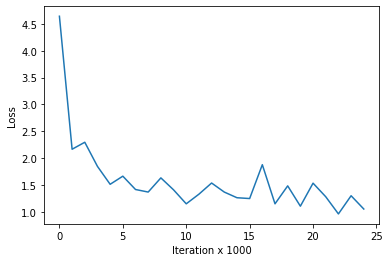

In [13]:
start_time = time.time()

loss_list = []

for iteration in range(NUM_ITER):

    hidden_and_cell_state = model.init_zero_state()
    optimizer.zero_grad()
    
    loss = 0.
    inputs, targets = draw_random_sample(textfile)
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    for c in range(TEXT_PORTION_SIZE):
        outputs, hidden_and_cell_state = model(inputs[c], hidden_and_cell_state)
        loss += torch.nn.functional.cross_entropy(outputs, targets[c].view(1))

    loss /= TEXT_PORTION_SIZE
    loss.backward()
    
    ### UPDATE MODEL PARAMETERS
    optimizer.step()

    ### LOGGING
    with torch.no_grad():
        if iteration % 200 == 0:
            print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
            print(f'Iteration {iteration} | Loss {loss.item():.2f}\n\n')
            print(evaluate(model, 'Th', 200), '\n')
            print(50*'=')
            
            loss_list.append(loss.item())
            plt.clf()
            plt.plot(range(len(loss_list)), loss_list)
            plt.ylabel('Loss')
            plt.xlabel('Iteration x 1000')
            plt.savefig('loss2.pdf')
            
plt.clf()
plt.ylabel('Loss')
plt.xlabel('Iteration x 1000')
plt.plot(range(len(loss_list)), loss_list)
plt.show()

In [44]:
prime_str = 'med'
predict_len = 4
temperature=0.8
hidden_and_cell_state = model.init_zero_state()
prime_input = char_to_tensor(prime_str)
predicted = prime_str
# Use priming string to "build up" hidden state
for p in range(len(prime_str) - 1):
     _, hidden_and_cell_state = model(prime_input[p].to(DEVICE), hidden_and_cell_state)
inp = prime_input[-1]

for p in range(predict_len):
    output, hidden_and_cell_state = model(inp.to(DEVICE), hidden_and_cell_state)
        
    # Sample from the network as a multinomial distribution
    output_dist = output.data.view(-1).div(temperature).exp()
    top_i = torch.multinomial(output_dist, 1)[0]
        
    # Add predicted character to string and use as next input
    predicted_char = string.printable[top_i]
    predicted += predicted_char
    inp = char_to_tensor(predicted_char)

print(predicted)

med log
